In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# package(s) for data handling
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.width = 0

import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
import matplotlib.dates as mdates



the current state is summarized by the number of turbines already built, the current time instance, the current location of each vessel (in port or offshore) and its current loading state, i.e. components for how many turbines are currently loaded on each vessel.

In [2]:
forecast_df = pd.read_csv("../demo/metocean_format_pieter_maart_2020_1_jaar.csv")
forecast_df = forecast_df.set_index(pd.to_datetime(forecast_df["Time"], dayfirst=True))

forecast_df = forecast_df.sort_index()

forecast_df["DateTime"] = [datetime.datetime.strptime(dt, '%d-%m-%Y %H:%M') for dt in forecast_df["Time"]]

In [3]:
forecast_df.head(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime
Time,,,,,,,,,
2020-03-01 00:00:00,2020,3,1,0,1,1-3-2020 00:00,7.4,1.832474,2020-03-01 00:00:00
2020-03-01 01:00:00,2020,3,1,1,2,1-3-2020 01:00,12.4,1.594841,2020-03-01 01:00:00
2020-03-01 02:00:00,2020,3,1,2,3,1-3-2020 02:00,18.4,1.612009,2020-03-01 02:00:00


In [4]:
uncertainty_df = pd.read_csv("../demo/uncertainty.csv")

uncertainty_df.head(3)

,HourIntoFuture,Uncertainty
0,0,0.000109
1,1,0.000218
2,2,0.000457


## Set planning horizon length

In [5]:
planning_horizon = 336  #Hours

In [27]:
# create dataframe which only consists of time information (to create new dataframes later on)
time_df = forecast_df.head(planning_horizon)
time_df = time_df.drop(['U10 [m/s]', 'Hs [m]'], axis=1)
time_df.head(3)

,Year,Month,Day,Hour,Hour.1,Time,DateTime,Uncertainty,Hs upper,Hs lower,installer_P(loading)_Hs,installer_P(sailingf)_Hs,installer_P(sailinge)_Hs,installer_P(installing)_Hs
Time,,,,,,,,,,,,,,
2020-03-01 00:00:00,2020,3,1,0,1,1-3-2020 00:00,2020-03-01 00:00:00,0.000109,1.832591,1.832357,0.0,1.0,1.0,1.0
2020-03-01 01:00:00,2020,3,1,1,2,1-3-2020 01:00,2020-03-01 01:00:00,0.000218,1.595076,1.594607,0.0,1.0,1.0,1.0
2020-03-01 02:00:00,2020,3,1,2,3,1-3-2020 02:00,2020-03-01 02:00:00,0.000457,1.612500,1.611518,0.0,1.0,1.0,1.0


In [7]:
forecast_df = forecast_df.head(planning_horizon)
average_Hs = forecast_df["Hs [m]"].sum()/len(forecast_df["Hs [m]"])
upper_bound = []
lower_bound = []

for hour in range(planning_horizon):
    upper_bound.append(forecast_df["Hs [m]"][hour]+uncertainty_df["Uncertainty"][hour]*average_Hs)
    lower_bound.append(forecast_df["Hs [m]"][hour]-uncertainty_df["Uncertainty"][hour]*average_Hs)
        
lower_bound = [0 if i < 0 else i for i in lower_bound]

In [8]:
col_one_list = uncertainty_df['Uncertainty'].tolist()
forecast_df['Uncertainty'] = col_one_list
forecast_df['Hs upper'] = upper_bound
forecast_df['Hs lower'] = lower_bound

In [9]:
forecast_df.head(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime,Uncertainty,Hs upper,Hs lower
Time,,,,,,,,,,,,
2020-03-01 00:00:00,2020,3,1,0,1,1-3-2020 00:00,7.4,1.832474,2020-03-01 00:00:00,0.000109,1.832591,1.832357
2020-03-01 01:00:00,2020,3,1,1,2,1-3-2020 01:00,12.4,1.594841,2020-03-01 01:00:00,0.000218,1.595076,1.594607
2020-03-01 02:00:00,2020,3,1,2,3,1-3-2020 02:00,18.4,1.612009,2020-03-01 02:00:00,0.000457,1.612500,1.611518


In [10]:
forecast_df.tail(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime,Uncertainty,Hs upper,Hs lower
Time,,,,,,,,,,,,
2020-03-14 21:00:00,2020,3,14,21,22,14-3-2020 21:00,8.2,1.128918,2020-03-14 21:00:00,0.643975,1.821090,0.436745
2020-03-14 22:00:00,2020,3,14,22,23,14-3-2020 22:00,7.6,1.217405,2020-03-14 22:00:00,0.645993,1.911747,0.523064
2020-03-14 23:00:00,2020,3,14,23,24,14-3-2020 23:00,5.2,1.248971,2020-03-14 23:00:00,0.648001,1.945471,0.552471


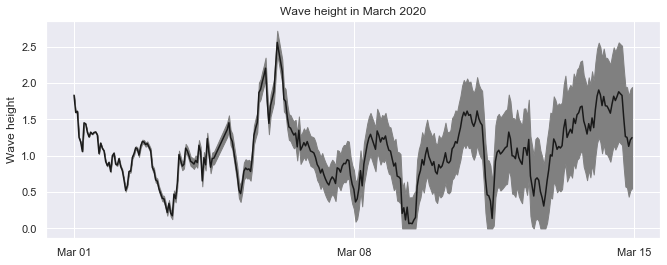

In [11]:
t0 = forecast_df.index[0]
t1 = forecast_df.index[-1]

fig, ax = plt.subplots()
ax.plot(forecast_df.loc[t0:t1, 'Hs [m]'], linestyle='-',color='k')
ax.fill_between(forecast_df.loc[t0:t1, 'DateTime'],forecast_df.loc[t0:t1, 'Hs lower'], 
                forecast_df.loc[t0:t1, 'Hs upper'],color='grey')
ax.set_ylabel('Wave height')
ax.set_title('Wave height in March 2020')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## For the installer:
#### Calculate probabilities of weather being good enough to perform activities 

In [12]:
# Installer limits:
limit_loading_Hs = 1.5
limit_installing_Hs = 2
limit_sailingf_Hs = 2.5
limit_sailinge_Hs = 2

In [13]:
# Calculate probability that weather is good enough to perform loading activity
probability_loading_Hs = []

for hour in range(planning_horizon):
    if forecast_df['Hs lower'][hour] < limit_loading_Hs < forecast_df['Hs upper'][hour]:
        probability_loading_Hs.append((limit_loading_Hs - forecast_df['Hs lower'][hour])/(forecast_df['Hs upper'][hour]-forecast_df['Hs lower'][hour])) 
    elif limit_loading_Hs > forecast_df['Hs upper'][hour]:
        probability_loading_Hs.append(1)
    elif limit_loading_Hs < forecast_df['Hs lower'][hour]:
        probability_loading_Hs.append(0)   
        
forecast_df['installer_P(loading)_Hs'] = probability_loading_Hs

In [14]:
# Calculate probability that weather is good enough to perform sailing full activity
probability_sailingf_Hs = []

for hour in range(planning_horizon):
    if lower_bound[hour] < limit_sailingf_Hs < upper_bound[hour]:
        probability_sailingf_Hs.append((limit_sailingf_Hs - lower_bound[hour])/(upper_bound[hour]-lower_bound[hour])) 
    elif limit_sailingf_Hs > upper_bound[hour]:
        probability_sailingf_Hs.append(1)
    elif limit_sailingf_Hs < lower_bound[hour]:
        probability_sailingf_Hs.append(0)   
        
forecast_df['installer_P(sailingf)_Hs'] = probability_sailingf_Hs

In [15]:
# Calculate probability that weather is good enough to perform sailing empty activity
probability_sailinge_Hs = []

for hour in range(planning_horizon):
    if forecast_df['Hs lower'][hour] < limit_sailinge_Hs < forecast_df['Hs upper'][hour]:
        probability_sailinge_Hs.append((limit_sailinge_Hs - forecast_df['Hs lower'][hour])/(forecast_df['Hs upper'][hour]-forecast_df['Hs lower'][hour])) 
    elif limit_sailinge_Hs > forecast_df['Hs upper'][hour]:
        probability_sailinge_Hs.append(1)
    elif limit_sailinge_Hs < forecast_df['Hs lower'][hour]:
        probability_sailinge_Hs.append(0)   
        
forecast_df['installer_P(sailinge)_Hs'] = probability_sailinge_Hs

In [16]:
# Calculate probability that weather is good enough to perform installing activity
probability_installing_Hs = []

for hour in range(planning_horizon):
    if forecast_df['Hs lower'][hour] < limit_installing_Hs < forecast_df['Hs upper'][hour]:
        probability_installing_Hs.append((limit_installing_Hs - forecast_df['Hs lower'][hour])/(forecast_df['Hs upper'][hour]-forecast_df['Hs lower'][hour])) 
    elif limit_installing_Hs > forecast_df['Hs upper'][hour]:
        probability_installing_Hs.append(1)
    elif limit_installing_Hs < forecast_df['Hs lower'][hour]:
        probability_installing_Hs.append(0)   
        
forecast_df['installer_P(installing)_Hs'] = probability_installing_Hs

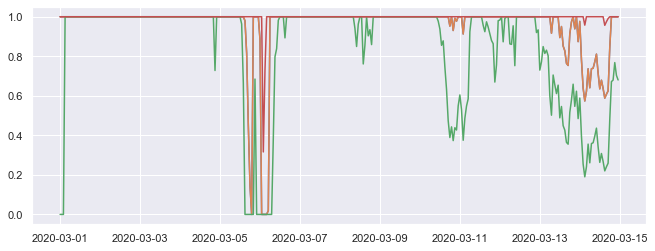

In [17]:
plt.plot(forecast_df['installer_P(installing)_Hs'])
plt.plot(forecast_df['installer_P(sailinge)_Hs'])
plt.plot(forecast_df['installer_P(loading)_Hs'])
plt.plot(forecast_df['installer_P(sailingf)_Hs'])

## For the installer:
#### Calculate (binary) workability matrix

In [18]:
# Set factor of risk you are willing to take
risk_factor_Hs = 0.75

In [19]:
# Set durations of activities (hours)
duration_installer_loading_Hs = 6
duration_installer_installing_Hs = 8
duration_installer_sailingf_Hs = 10
duration_installer_sailinge_Hs = 8

In [20]:
workability_installer_df = time_df.head(planning_horizon) #initialize dataframe
binary_workability_installer_df = time_df.head(planning_horizon)
binary_workability_installer_plot_df = time_df.copy()
workability_installer_loading_Hs = []
workability_installer_installing_Hs = []
workability_installer_sailingf_Hs = []
workability_installer_sailinge_Hs = []
binary_workability_installer_loading_Hs = []
binary_workability_installer_installing_Hs = []
binary_workability_installer_sailingf_Hs = []
binary_workability_installer_sailinge_Hs = []
binary_workability_installer_loading_Hs_plot = []
binary_workability_installer_installing_Hs_plot = []
binary_workability_installer_sailingf_Hs_plot = []
binary_workability_installer_sailinge_Hs_plot = []

In [21]:
# Determine workability probability per starting hour for loading by the installer
for hour in range(planning_horizon-duration_installer_loading_Hs):
    omega = 1
    for duration in range(duration_installer_loading_Hs):
        omega = omega * forecast_df['installer_P(loading)_Hs'][hour+duration] 
    workability_installer_loading_Hs.append(omega)    
    if  workability_installer_loading_Hs[hour] >= risk_factor_Hs:
        binary_workability_installer_loading_Hs.append(1)
        binary_workability_installer_loading_Hs_plot.append(1)
    else: 
        binary_workability_installer_loading_Hs.append(0)
        binary_workability_installer_loading_Hs_plot.append(None)
        
for finish in range(duration_installer_loading_Hs):
    workability_installer_loading_Hs.append(0)
    binary_workability_installer_loading_Hs.append(0)
    binary_workability_installer_loading_Hs_plot.append(None)
    
workability_installer_df['W loading'] = workability_installer_loading_Hs
binary_workability_installer_df['BinW loading'] = binary_workability_installer_loading_Hs
binary_workability_installer_plot_df['BinW loading'] = binary_workability_installer_loading_Hs_plot

In [22]:
# Determine workability probability per starting hour for installing by the installer
for hour in range(planning_horizon-duration_installer_installing_Hs):
    omega = 1
    for duration in range(duration_installer_installing_Hs):
        omega = omega * forecast_df['installer_P(installing)_Hs'][hour+duration] 
    workability_installer_installing_Hs.append(omega)    
    if  workability_installer_installing_Hs[hour] >= risk_factor_Hs:
        binary_workability_installer_installing_Hs.append(1)
        binary_workability_installer_installing_Hs_plot.append(1)
    else: 
        binary_workability_installer_installing_Hs.append(0)
        binary_workability_installer_installing_Hs_plot.append(None)
        
for finish in range(duration_installer_installing_Hs):
    workability_installer_installing_Hs.append(0)
    binary_workability_installer_installing_Hs.append(0)
    binary_workability_installer_installing_Hs_plot.append(None)
    
workability_installer_df['W installing'] = workability_installer_installing_Hs
binary_workability_installer_df['BinW installing'] = binary_workability_installer_installing_Hs
binary_workability_installer_plot_df['BinW installing'] = binary_workability_installer_installing_Hs_plot

In [23]:
# Determine workability probability per starting hour for sailing full by the installer
for hour in range(planning_horizon-duration_installer_sailingf_Hs):
    omega = 1
    for duration in range(duration_installer_sailingf_Hs):
        omega = omega * forecast_df['installer_P(sailingf)_Hs'][hour+duration] 
    workability_installer_sailingf_Hs.append(omega)    
    if  workability_installer_sailingf_Hs[hour] >= risk_factor_Hs:
        binary_workability_installer_sailingf_Hs.append(1)
        binary_workability_installer_sailingf_Hs_plot.append(1)
    else: 
        binary_workability_installer_sailingf_Hs.append(0)
        binary_workability_installer_sailingf_Hs_plot.append(None)
        
for finish in range(duration_installer_sailingf_Hs):
    workability_installer_sailingf_Hs.append(0)
    binary_workability_installer_sailingf_Hs.append(0)
    binary_workability_installer_sailingf_Hs_plot.append(None)
    
workability_installer_df['W sailingf'] = workability_installer_sailingf_Hs
binary_workability_installer_df['BinW sailingf'] = binary_workability_installer_sailingf_Hs
binary_workability_installer_plot_df['BinW sailingf'] = binary_workability_installer_sailingf_Hs_plot

In [24]:
# Determine workability probability per starting hour for sailing empty by the installer
for hour in range(planning_horizon-duration_installer_sailinge_Hs):
    omega = 1
    for duration in range(duration_installer_sailinge_Hs):
        omega = omega * forecast_df['installer_P(sailinge)_Hs'][hour+duration] 
    workability_installer_sailinge_Hs.append(omega)    
    if  workability_installer_sailinge_Hs[hour] >= risk_factor_Hs:
        binary_workability_installer_sailinge_Hs.append(1)
        binary_workability_installer_sailinge_Hs_plot.append(1)
    else: 
        binary_workability_installer_sailinge_Hs.append(0)
        binary_workability_installer_sailinge_Hs_plot.append(None)
        
for finish in range(duration_installer_sailinge_Hs):
    workability_installer_sailinge_Hs.append(0)
    binary_workability_installer_sailinge_Hs.append(0)
    binary_workability_installer_sailinge_Hs_plot.append(None)
    
workability_installer_df['W sailinge'] = workability_installer_sailinge_Hs
binary_workability_installer_df['BinW sailinge'] = binary_workability_installer_sailinge_Hs
binary_workability_installer_plot_df['BinW sailinge'] = binary_workability_installer_sailinge_Hs_plot

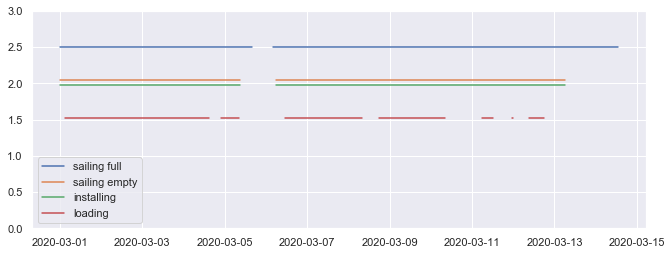

In [29]:
workability_plot = plt.plot(binary_workability_installer_plot_df['BinW sailingf']*limit_sailingf_Hs+0)
workability_plot = plt.plot(binary_workability_installer_plot_df['BinW sailinge']*limit_sailinge_Hs+0.05)
workability_plot = plt.plot(binary_workability_installer_plot_df['BinW installing']*limit_installing_Hs-0.025)
workability_plot = plt.plot(binary_workability_installer_plot_df['BinW loading']*limit_loading_Hs+0.025)
workability_plot = plt.legend(['sailing full','sailing empty', 'installing', 'loading'])
workability_plot = plt.ylim(0,max(limit_loading_Hs,limit_installing_Hs,limit_sailingf_Hs,limit_sailinge_Hs)+0.5)